In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf

import sys
sys.path.append("..")
from utils import *

In [2]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

salmon_data = import_salmon_data(data_URL, rename_cols=True)

# Supply commodity data from yahoo finance
commodity_data = yf.download(['ZW=F', 'ZS=F'],
    start=salmon_data.index[0], 
    end=salmon_data.index[-1], 
    interval='1wk', 
    progress=False
)['Adj Close'].rename(columns={'ZW=F': 'Wheat', 'ZS=F': 'Soybean'})

data = pd.concat([salmon_data, commodity_data.reindex(salmon_data.index)], axis=1).dropna()

display(data)

display(data.corr())
data.to_csv('supply_data.csv')

,Price,Volume,Soybean,Wheat
Date,,,,
2000-09-11,29.51,5597,493.75,254.50
2000-09-18,29.33,5854,491.00,247.50
2000-09-25,29.18,6081,499.00,258.00
2000-10-02,28.44,5978,486.00,266.50
2000-10-09,27.76,5637,473.25,272.75
...,...,...,...,...
2023-08-07,80.26,21060,1401.25,626.75
2023-08-14,78.14,22698,1362.75,613.25
2023-08-21,76.87,24089,1381.00,593.25


,Price,Volume,Soybean,Wheat
Price,1.000000,0.604198,0.470932,0.348917
Volume,0.604198,1.000000,0.601888,0.497791
Soybean,0.470932,0.601888,1.000000,0.872472
Wheat,0.348917,0.497791,0.872472,1.000000


# Supply

### Fish Feed

- Soybean
- Wheat
- Fishmeal

,Price,Volume
Date,,
2000-01-31,31.30,3831
2000-02-07,32.53,4415
2000-02-14,32.46,4617
2000-02-21,32.19,4463
2000-02-28,32.04,4025


array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

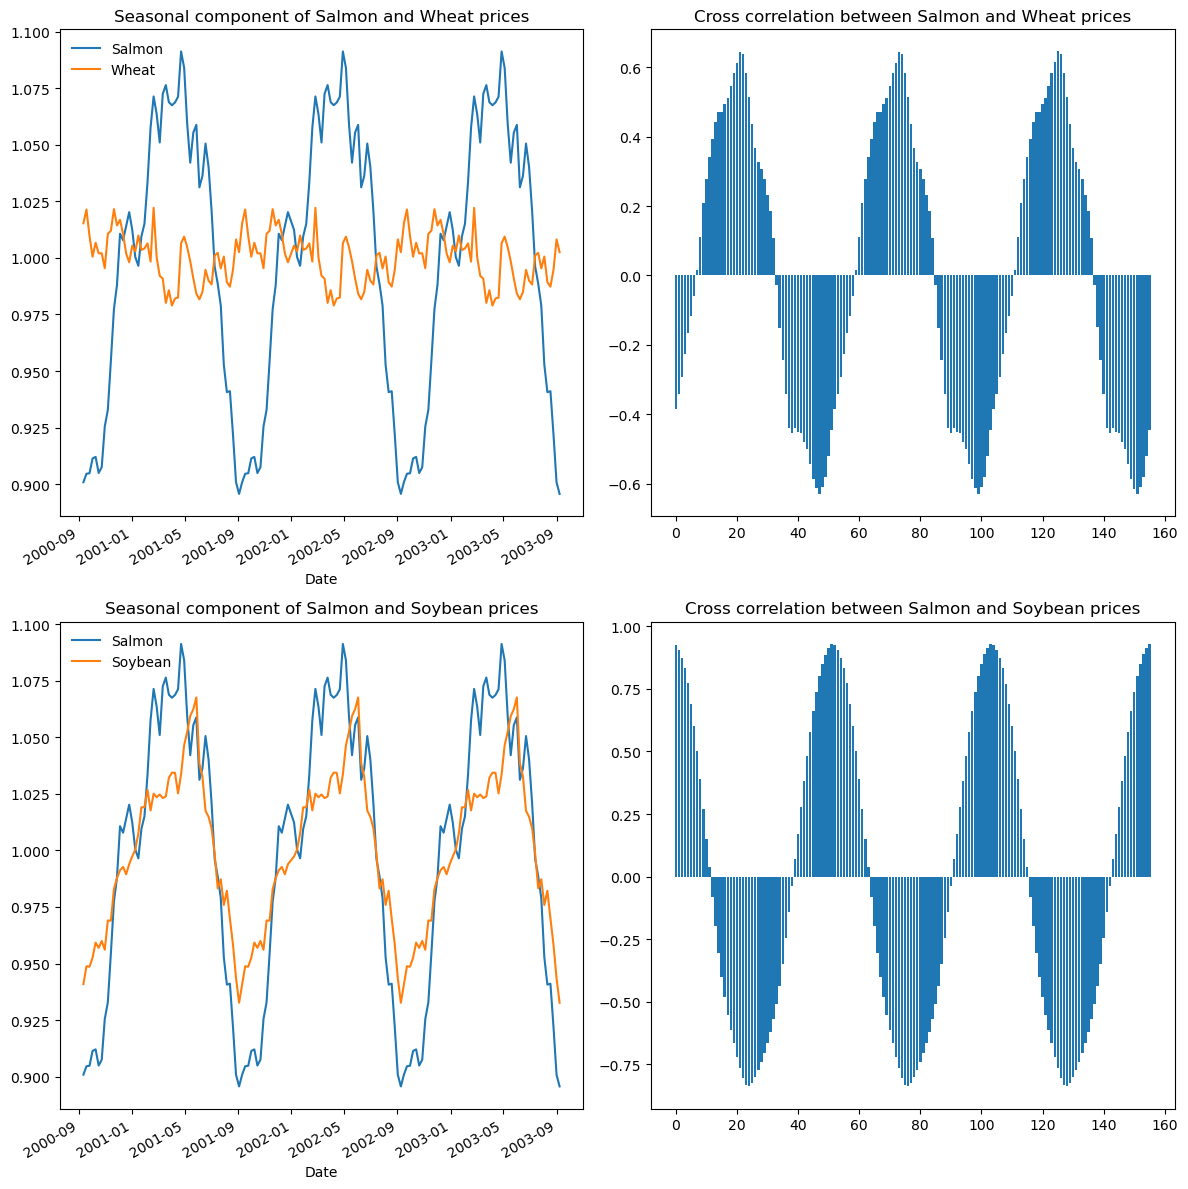

In [3]:

def STL(data: pd.DataFrame, period: int=50):
    seasonal = seasonal_decompose(
        data, model="multiplicative", period=period
    )
    return seasonal

display(salmon_data.head())

models = {
    'Salmon': STL(data['Price'], period=52),
    'Wheat': STL(data['Wheat'], period=52), # Wheat
    'Soybean': STL(data['Soybean'], period=52), # Soybean
}

periods = 52 * 3

fig, axs = plt.subplots(len(models) -1, 2, figsize=(12, 12))

display(axs)

for i, commodity in enumerate(list(models.keys())[1:]):
    models['Salmon'].seasonal[:periods].plot(ax=axs[i, 0], label='Salmon')
    models[commodity].seasonal[:periods].plot(ax=axs[i, 0], label=commodity)
    cross_corr = ccf(models['Salmon'].seasonal, models[commodity].seasonal)
    axs[i, 1].bar(range(periods), cross_corr[:periods])
    axs[i, 0].legend(frameon=False)
    axs[i, 0].set_title(f'Seasonal component of Salmon and {commodity} prices')
    axs[i, 1].set_title(f'Cross correlation between Salmon and {commodity} prices')

fig.tight_layout()